##  Importing Dependencies
   We shall start by importing all the neccessary libraries. 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.1.0


#  Dataset Preprocessing
In this notebook, I am using **Sentiment-140** from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It contains a labels data of 1.6 Million Tweets.

In [2]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


You can see the columns are without any proper names. Lets rename them for our reference

In [3]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [4]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [5]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Here are decoding the labels. We map **0 -> Negative and 1 -> Positive** as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution. 

In [6]:
"""val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")"""

'val_count = df.sentiment.value_counts()\n\nplt.figure(figsize=(8,4))\nplt.bar(val_count.index, val_count.values)\nplt.title("Sentiment Data Distribution")'

It's a very good dataset without any skewness. 

Now let us explore the data we having here... 

In [7]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
1569017,Positive,@davidon backseat of the new vios ya. definite...
390603,Negative,And it rains and rains. What a saturday evening
845839,Positive,"you have awesome red hair, gorgeous eyes and a..."
201607,Negative,@VirtualCD_CTEn Morning!! It's a perfect day h...
520518,Negative,Don't you hate it wgen you wait sooo long for ...
1450008,Positive,"Yesterday's missing stuff has reappeared, comp..."
276014,Negative,Graduated!!! done with the awesome weekend. no...
1498014,Positive,Home from a long day of shopping. No miso soup...
900046,Positive,goodnight twitterville! really enjoyed pearl h...
945906,Positive,"Well, currently I'm on the deck but you know w..."


Looks like we have a nasty data in text. Because in general we use lot of punctuations and other words without any contextual meaning. It have no value as feature to the model we are training. So we need to get rid of them.

# Text Preprocessing
Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods. Let's continue



In [8]:
emoticon_dict = {
    ":)": "smile",
    ":-)": "smile",
    ":(": "sad",
    ":-(": "sad",
    ":D": "laugh",
    ":-D": "laugh",
    ":P": "playful",
    ":-P": "playful",
    ";)": "wink",
    ";-)": "wink",
    ":/": "unsure",
    ":-/": "unsure",
    ":|": "neutral",
    ":-|": "neutral",
    ":'(": "cry",
    "<3": "love",
    ":o": "surprise",
    ":-o": "surprise"
    # Add more emoticons as needed
}


In [9]:
stop_words = stopwords.words('english')

# Remove important stop words for sentiment analysis
important_words = [
    'not', 'no', 'never', 'but', 'however', 'very', 'too', 'so', 'just', 
    'only', 'almost', 'quite', 'rather', 'barely', 'hardly', 'scarcely', 
    'yet', 'despite', 'really', 'definitely', 'absolutely', 'unless', 
    'otherwise', 'if', 'what', 'how', 'why'
]

for word in important_words:
    if word in stop_words:
        stop_words.remove(word)

stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
# Define slang dictionary outside the function
slang_dict = {"thx": "thanks", "u": "you", "ur": "your", "gr8": "great", "luv": "love", "b4": "before", "im": "i'm"}


In [11]:
def preprocess(text, stem=False):
    # Step 1: Clean using regex (remove mentions, links, etc.)
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()

    # Step 2: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 3: Replace emoticons with their text meanings
    text = ' '.join([emoticon_dict[token] if token in emoticon_dict else token for token in text.split()])

    # Step 4: Expand slang/abbreviations
    text = ' '.join([slang_dict[token] if token in slang_dict else token for token in text.split()])

    # Step 5: Tokenize, remove stop words, and optionally stem
    tokens = []
    for token in text.split():
        '''if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)'''
        tokens.append(token)

    # Step 6: Return the cleaned text
    return " ".join(tokens)


In [12]:
df.text = df.text.apply(lambda x: preprocess(x))

In [13]:
df.head()

,sentiment,text
0,Negative,awww that s a bummer you shoulda got david car...
1,Negative,is upset that he can t update his facebook by ...
2,Negative,i dived many times for the ball managed to sav...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,no it s not behaving at all i m mad why am i h...


In [14]:

'''# Count the number of words in each tweet
tweet_lengths = df.text.apply(lambda x: len(x.split()))

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Number of Words in Tweets", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()'''

'# Count the number of words in each tweet\ntweet_lengths = df.text.apply(lambda x: len(x.split()))\n\n# Plot the distribution\nplt.figure(figsize=(10, 6))\nplt.hist(tweet_lengths, bins=50, color=\'blue\', alpha=0.7)\nplt.title("Distribution of Number of Words in Tweets", fontsize=16)\nplt.xlabel("Number of Words", fontsize=14)\nplt.ylabel("Frequency", fontsize=14)\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.7)\nplt.show()'

## Train and Test Split

In [15]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [16]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=0) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [17]:
train_data.head(10)

,sentiment,text
1519669,Positive,thanks i like your pic as well
1245284,Positive,who wore it better cosgrovemirana or mileycyrus
1299040,Positive,can t get it to work as yet thinking there mus...
200654,Negative,hmm not sure if i know how to fill out a ticke...
699963,Negative,i m so sorry lots of peaceful healing vibes fo...
1275037,Positive,conan o brien yay love him
587150,Negative,at home doing some homework posted to my my si...
590999,Negative,brainsurgerysaywhatnow we just talked and you ...
1557221,Positive,ha ha he spanked you i love it ok so you gotta...
749832,Negative,my head hurts


# Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization.**


`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`word_index` contains the index for each word

`vocab_size` represents the total number of word in the data corpus

In [18]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Using TensorFlow backend.


Vocabulary Size : 276577


Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from `pad_sequence` to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [19]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [20]:
labels = train_data.sentiment.unique().tolist()

### Label Encoding 
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [21]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


# Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it. 

**Word Embedding** is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use **Transfer Learning**. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like **GloVe & Word2Vec** gives more insights for a word which can be used for classification. If you want to learn more about the Word Embedding, please refer some links that I left at the end of this notebook.


In this notebook, I use **GloVe Embedding from Stanford AI** which can be found [here](https://nlp.stanford.edu/projects/glove/)

In [22]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2025-01-09 13:11:11--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-01-09 13:11:11--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z  80%[===============>    ]   1.14G  5.10MB/s    eta 58s    

In [ ]:
GLOVE_EMB = '/kaggle/working/glove.twitter.27B.100d.txt'
EMBEDDING_DIM = 100
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [26]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training - LSTM

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction. 

For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors. 

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [27]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
from tensorflow.keras.optimizers import Adam

In [29]:

from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # Score computation
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        
        # Apply attention weights to inputs
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


# grid search

In [30]:
def build_model(lstm_units, dropout_rate, learning_rate):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=0.2, return_sequences=True))(x)
    
    # Add attention mechanism
    x = Attention()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(sequence_input, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [31]:
# from grid search previously
best_batch_size, best_learning_rate, best_lstm_units, best_dropout_rate = 512,0.001,128,0.2

In [32]:
from tensorflow.keras.layers import GlobalMaxPooling1D

In [33]:


# Build the best model
final_model = build_model(best_lstm_units, best_dropout_rate, best_learning_rate)

# Train on the entire training set
history = final_model.fit(
    x_train, y_train,
    batch_size=best_batch_size,
    epochs=75,  # Train for more epochs
    validation_data=(x_test, y_test),
    verbose=2
)

# Save the final model
#final_model.save("best_lstm_model.h5")


Train on 1280000 samples, validate on 320000 samples
Epoch 1/75
1280000/1280000 - 162s - loss: 0.4705 - accuracy: 0.7732 - val_loss: 0.4203 - val_accuracy: 0.8069
Epoch 2/75
1280000/1280000 - 153s - loss: 0.4309 - accuracy: 0.7990 - val_loss: 0.4089 - val_accuracy: 0.8125
Epoch 3/75
1280000/1280000 - 153s - loss: 0.4187 - accuracy: 0.8063 - val_loss: 0.3957 - val_accuracy: 0.8194
Epoch 4/75
1280000/1280000 - 153s - loss: 0.4113 - accuracy: 0.8104 - val_loss: 0.3907 - val_accuracy: 0.8225
Epoch 5/75
1280000/1280000 - 153s - loss: 0.4054 - accuracy: 0.8141 - val_loss: 0.3860 - val_accuracy: 0.8247
Epoch 6/75
1280000/1280000 - 152s - loss: 0.4015 - accuracy: 0.8163 - val_loss: 0.3839 - val_accuracy: 0.8253
Epoch 7/75
1280000/1280000 - 153s - loss: 0.3978 - accuracy: 0.8183 - val_loss: 0.3807 - val_accuracy: 0.8279
Epoch 8/75
1280000/1280000 - 152s - loss: 0.3948 - accuracy: 0.8201 - val_loss: 0.3799 - val_accuracy: 0.8291
Epoch 9/75
1280000/1280000 - 152s - loss: 0.3927 - accuracy: 0.8213

### Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. 



In [34]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


# Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

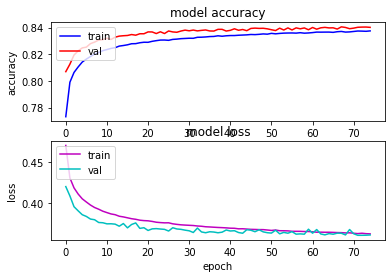

In [35]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['train', 'val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

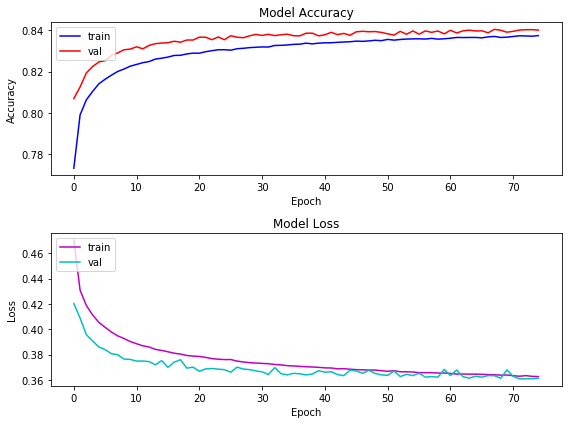

In [36]:
# Assuming you have your history object 

s, (at, al) = plt.subplots(2, 1, figsize=(8, 6))  # Adjust figsize as needed

# Plot accuracy
at.plot(history.history['accuracy'], c='b', label='train')
at.plot(history.history['val_accuracy'], c='r', label='val')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(loc='upper left')

# Plot loss
al.plot(history.history['loss'], c='m', label='train')
al.plot(history.history['val_loss'], c='c', label='val')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(loc='upper left')

plt.tight_layout()  # Improve spacing between subplots
plt.show()

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

In [37]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = final_model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

320000/320000 [==============================] - 4s 12us/sample


### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [38]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.4f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

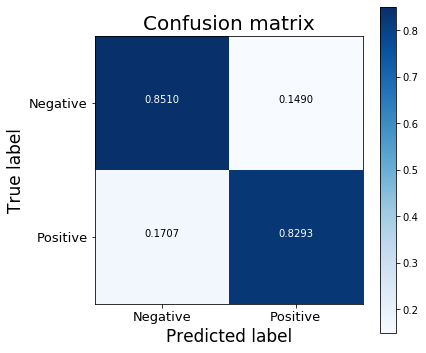

In [39]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [40]:
print(classification_report(list(test_data.sentiment), y_pred_1d, digits=4))

              precision    recall  f1-score   support

    Negative     0.8326    0.8510    0.8417    159815
    Positive     0.8480    0.8293    0.8385    160185

    accuracy                         0.8401    320000
   macro avg     0.8403    0.8401    0.8401    320000
weighted avg     0.8403    0.8401    0.8401    320000



It's a pretty good model we trained here in terms of NLP. Around 80% accuracy is good enough considering the baseline human accuracy also pretty low in these tasks.

In [41]:
# Error Analysis: Misclassified Tweets
test_data['Predicted Sentiment'] = y_pred_1d
misclassified = test_data[test_data['sentiment'] != test_data['Predicted Sentiment']]

# Display some misclassified examples
print("Sample Misclassified Tweets:")
print(misclassified[['text', 'sentiment', 'Predicted Sentiment']].head(10))

# Save misclassified tweets for manual analysis
# Save misclassified tweets to a CSV file
output_file_path = "/kaggle/working/misclassified_tweets.csv"  # Kaggle working directory
misclassified.to_csv(output_file_path, index=False)

print(f"Misclassified tweets saved to {output_file_path}")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Sample Misclassified Tweets:
                                                      text sentiment  \
1339637                                       reply me pls  Positive   
217849   song of my life now your love is a lie simple ...  Negative   
792159   is curently at college doing nothing that has ...  Negative   
220737     watching the last leno so glad i got to go once  Negative   
1334666            i dropped your books off in the library  Positive   
441478                             i do more that anything  Negative   
29570    s ok i was confused for a moment i have to agr...  Negative   
1491121  oh my jeebus i slept allll day how wonderful i...  Positive   
1522865  ummm its gettting bettterrr than before but it...  Positive   
749873   huh turns out i m like marmite when did i stop...  Negative   

        Predicted Sentiment  
1339637            Negative  
217849             Positive  
792159             Positive  
220737             Positive  
1334666            Negative 